In [1]:
import os
import cv2
import numpy as np

In [2]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    img = cv2.resize(img, (224, 224))  # Resize to 224x224
    img = img.astype('float32') / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

def load_data_from_folder(folder_path, label):
    
    images = []
    ears = []
    labels = []
    
    for uuid_folder in os.listdir(folder_path):
        uuid_path = os.path.join(folder_path, uuid_folder)
        if not os.path.isdir(uuid_path):
            continue
        
        # Load EAR value
        ear_file = os.path.join(uuid_path, 'EAR.txt')
        with open(ear_file, 'r') as file:
            ear_value = float(file.read().strip())
        
        # Load images
        for img_file in os.listdir(uuid_path):
            if img_file.endswith('.jpg'):
                img_path = os.path.join(uuid_path, img_file)
                img = preprocess_image(img_path)
                images.append(img)
                ears.append([ear_value])
                labels.append(label)
    
    return np.array(images), np.array(ears), np.array(labels)

# Load data
drowsy_folder = 'dataset/drowsy'
alert_folder = 'dataset/alert'

drowsy_images, drowsy_ears, drowsy_labels = load_data_from_folder(drowsy_folder, 0)  # 0 for drowsy
alert_images, alert_ears, alert_labels = load_data_from_folder(alert_folder, 1)  # 1 for alert

# Combine datasets
images = np.concatenate([drowsy_images, alert_images], axis=0)
ears = np.concatenate([drowsy_ears, alert_ears], axis=0)
labels = np.concatenate([drowsy_labels, alert_labels], axis=0)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

# Define the image input branch
image_input = Input(shape=(224, 224, 1), name='image_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Define the EAR input branch
ear_input = Input(shape=(1,), name='ear_input')
y = Dense(16, activation='relu')(ear_input)

# Concatenate the outputs from both branches
combined = Concatenate()([x, y])

# Fully connected layers after concatenation
z = Dense(32, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z)

# Create the model
model = Model(inputs=[image_input, ear_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 224, 224, 32)      │             320 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 224, 224, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 112, 112, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 112, 112, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 64)        │               0 │ batch_normalization_1[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 56, 56, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 56, 56, 128)       │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 28, 28, 128)       │               0 │ batch_normalization_2[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 28, 28, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 28, 28, 256)       │           1,024 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 14, 14, 256)       │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 50176)             │               

 Total params: 3,603,745 (13.75 MB)

 Trainable params: 3,602,785 (13.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [5]:
from tensorflow import keras
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=7,
                                        start_from_epoch=4,
                                         restore_best_weights=True)

In [6]:
# Example data (replace with your actual data)
# images, ears, labels should be numpy arrays from the loading function

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_images_train, X_images_val, X_ears_train, X_ears_val, y_train, y_val = train_test_split(
    images, ears, labels, test_size=0.2, random_state=101
)

# Train the model
history = model.fit(
    [X_images_train, X_ears_train], y_train,
    epochs=100,
    callbacks=[callback],
    validation_batch_size = 32,
    batch_size=32,
    validation_data=([X_images_val, X_ears_val], y_val)
)

# Evaluate the model
loss, accuracy = model.evaluate([X_images_val, X_ears_val], y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4920 - loss: 2.8472 - val_accuracy: 0.4763 - val_loss: 3.8436
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5063 - loss: 0.7658 - val_accuracy: 0.4734 - val_loss: 2.5075
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5267 - loss: 0.7021 - val_accuracy: 0.5533 - val_loss: 1.8741
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5344 - loss: 0.7713 - val_accuracy: 0.4763 - val_loss: 3.0953
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5352 - loss: 0.6924 - val_accuracy: 0.4763 - val_loss: 7.4376
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5317 - loss: 0.6884 - val_accuracy: 0.5533 - val_loss: 2.9174
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5574 - loss: 0.7009 - val_accuracy: 0.5237 - val_loss: 4.7403
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6015 - loss: 0.6992 - val_accuracy: 0.5444 - v

In [7]:
image_input_shape = (224, 224, 1)  # Grayscale image

# Image Branch
image_input = Input(shape=image_input_shape, name='image_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# EAR Branch
ear_input = Input(shape=(1,), name='ear_input')
y = Dense(10, activation='relu')(ear_input)
y = Dense(20, activation='relu')(y)

# Concatenate branches
concat = Concatenate()([x, y])
z = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(z)

# Build the model
model = Model(inputs=[image_input, ear_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 224, 224, 32)      │             320 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 112, 112, 32)      │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 112, 112, 64)      │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 56, 56, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 56, 56, 128)       │          73,856 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 28, 28, 128)       │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ear_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 100352)            │               0 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 10)                │              20 │ ear_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │      25,690,368 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 20)                │             220 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 276)               │               0 │ dense_4[0][0],             │
│                               │                           │                 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 64)                │          17,728 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 1)                 │              65 │ dense_7[0][0]              │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 25,801,073 (98.42 MB)

 Trainable params: 25,801,073 (98.42 MB)

 Non-trainable params: 0 (0.00 B)

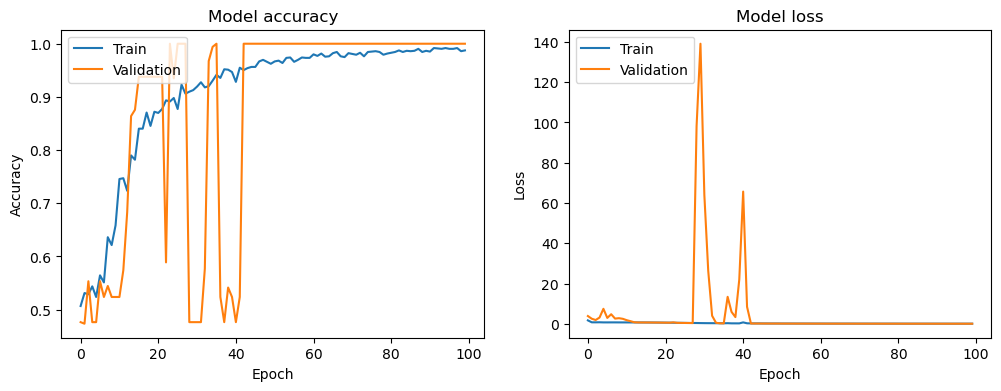

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


In [10]:
model.save('Model1.h5')